# 👨‍⚕️ Projet Stroke Alert 👩‍⚕️

## 1. Préparation du jeu de données

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [21]:
print(f"Le dataFrame comporte {df.shape[0]} lignes, pour {df.shape[1]} colonnes. ")

Le dataFrame comporte 5110 lignes, pour 12 colonnes. 


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [23]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### ► Valeurs manquantes

On va remplacer les champs "Unknown" de la colonne "smoking_status" par des N/A. 

In [100]:
df['smoking_status'] = df['smoking_status'].replace('Unknown', np.nan)

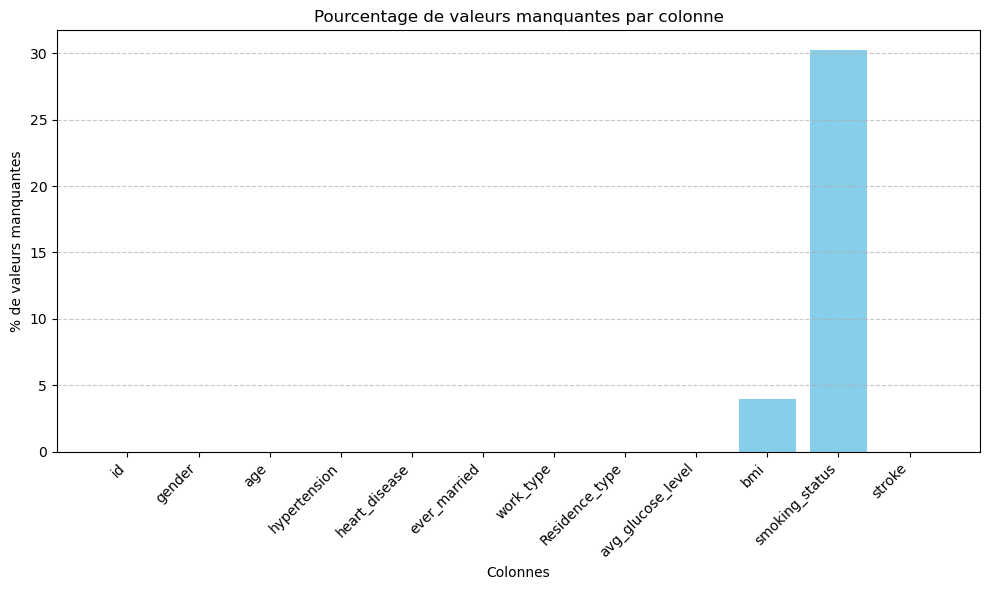

In [62]:
missing_percentages = [(1 - df[column].dropna().shape[0] / df[column].shape[0]) * 100 for column in df.columns]

plt.figure(figsize=(10, 6))
plt.bar(df.columns, missing_percentages, color='skyblue')
plt.xlabel('Colonnes')
plt.ylabel('% de valeurs manquantes')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Dans un contexte médical, impossible d'abandonner ces données. Pour L'IMC on pourra imputer la moyenne aux valeurs manquantes.

### ► Outliers

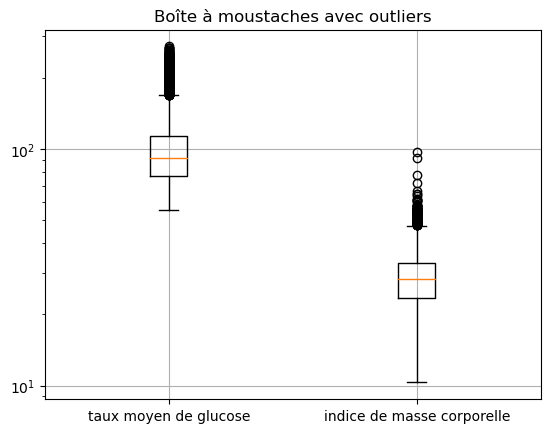

In [25]:
taux_moyen_glucose = df['avg_glucose_level']
indice_masse_corporelle = df['bmi'].dropna()
plt.boxplot([taux_moyen_glucose,indice_masse_corporelle], showfliers=True)
plt.xticks([1,2],['taux moyen de glucose','indice de masse corporelle'])
plt.yscale('log')
plt.title("Boîte à moustaches avec outliers")
plt.grid(True)
plt.show()

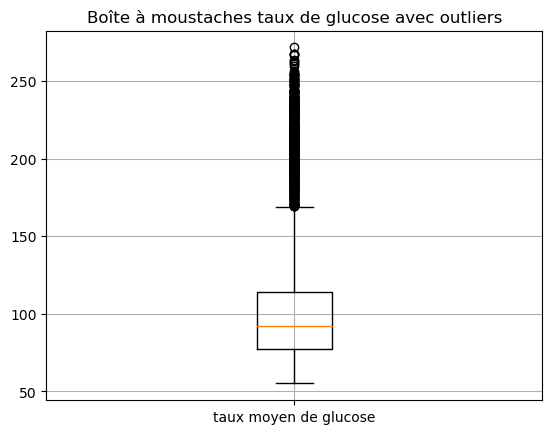

In [26]:
taux_moyen_glucose = df['avg_glucose_level']
plt.boxplot(taux_moyen_glucose, showfliers=True)
plt.xticks([1],['taux moyen de glucose'])
plt.title("Boîte à moustaches taux de glucose avec outliers")
plt.grid(True)
plt.show()

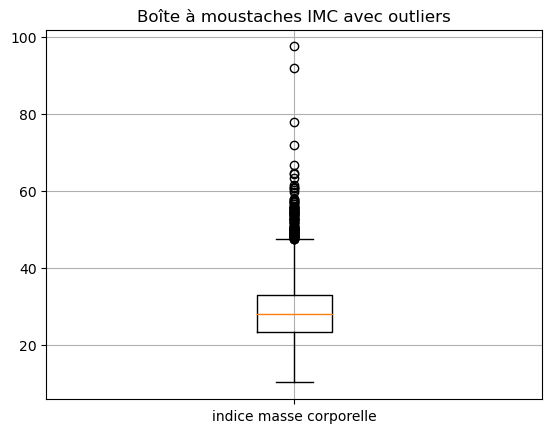

In [27]:
indice_masse_corporelle = df['bmi'].dropna()
plt.boxplot(indice_masse_corporelle, showfliers=True)
plt.xticks([1],['indice masse corporelle'])
plt.title("Boîte à moustaches IMC avec outliers")
plt.grid(True)
plt.show()

In [98]:
df.loc[(df['bmi'] > 50) & (df['stroke'] == 1)].count()

id                   1
gender               1
age                  1
hypertension         1
heart_disease        1
ever_married         1
work_type            1
Residence_type       1
avg_glucose_level    1
bmi                  1
smoking_status       1
stroke               1
dtype: int64

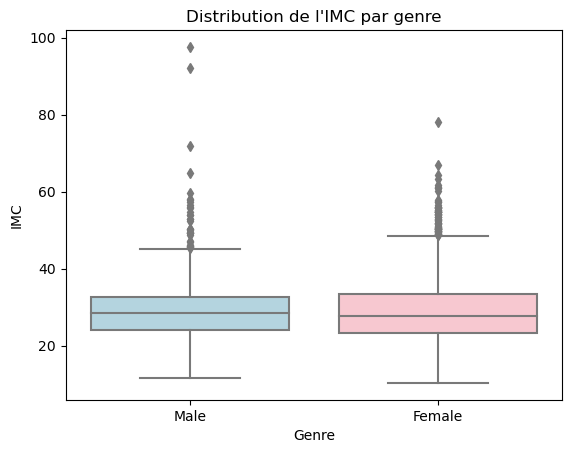

In [82]:
sns.boxplot(data=df, x="gender", y="bmi", palette=['lightblue','pink']);
plt.xlabel("Genre")
plt.ylabel("IMC")
plt.title("Distribution de l'IMC par genre")
plt.show()

Ici, les outliers ne sont pas des valeurs abérantes. On les garde donc dans notre jeu de données.

In [10]:
df_patient_avc = df.loc[df['stroke'] == 1,:]
df_patient_no_avc = df.loc[df['stroke'] == 0,:]
print(f"Dans notre échantillon, il y a {df_patient_avc.shape[0]} patients ayant contracté un AVC.")

Dans notre échantillon, il y a 249 patients ayant contracté un AVC.


## 2. Analyse bivariée par rapport au risque d'avoir un AVC

### ► Genre 

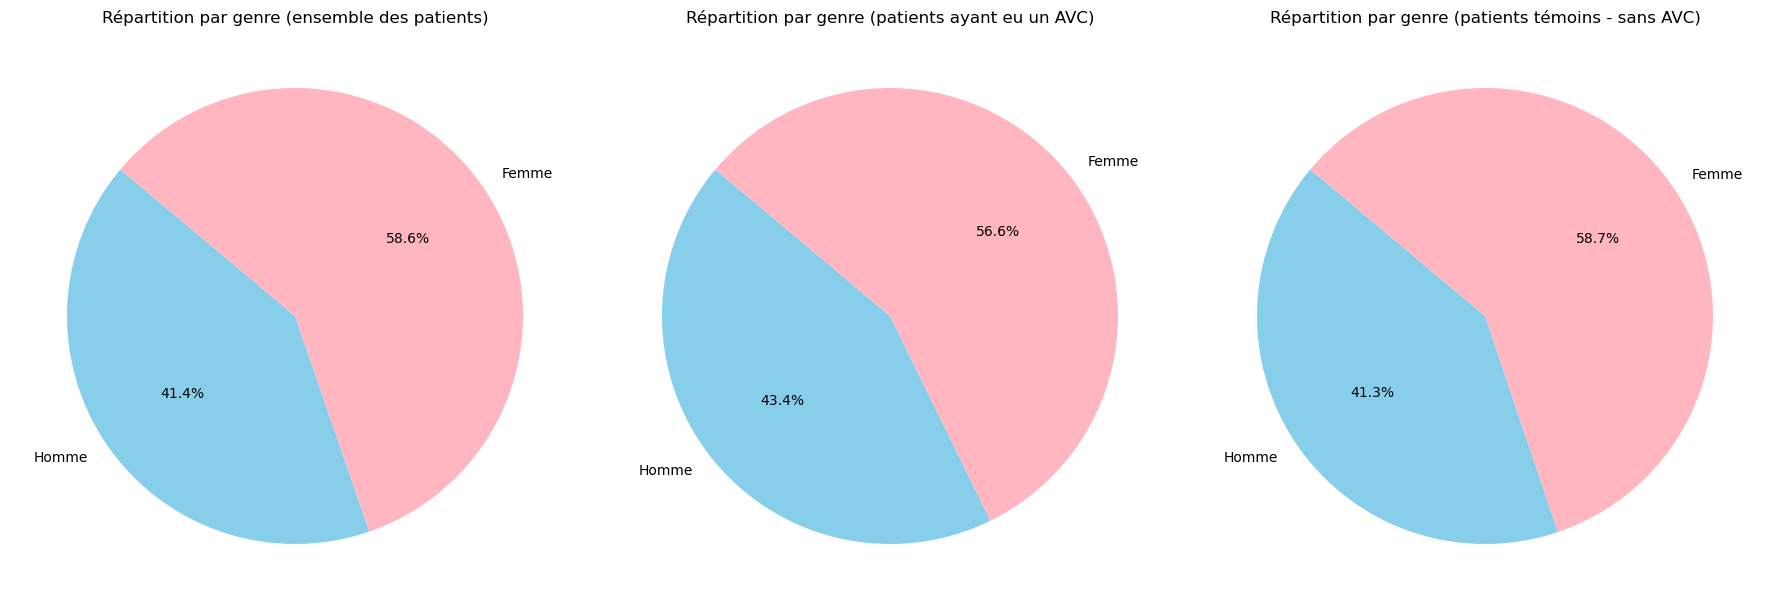

In [85]:
# Données pour le premier camembert (ensemble des patients)
homme_all = (df['gender'] == 'Male').sum()
femme_all = (df['gender'] == 'Female').sum()
nombre_patients_all = [homme_all, femme_all]
labels_all = ['Homme', 'Femme']
colors_all = ['skyblue', 'lightpink']

# Données pour le deuxième camembert (patients ayant eu un AVC)
homme_avc = (df_patient_avc['gender'] == 'Male').sum()
femme_avc = (df_patient_avc['gender'] == 'Female').sum()
nombre_patients_avc = [homme_avc, femme_avc]
labels_avc = ['Homme', 'Femme']
colors_avc = ['skyblue', 'lightpink']

# Données pour le troisième camembert (patients témoins - sans AVC)
homme_no_avc = (df_patient_no_avc['gender'] == 'Male').sum()
femme_no_avc = (df_patient_no_avc['gender'] == 'Female').sum()
nombre_patients_no_avc = [homme_no_avc, femme_no_avc]
labels_no_avc = ['Homme', 'Femme']
colors_no_avc = ['skyblue', 'lightpink']

# Créer le subplot avec trois camemberts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Premier camembert : ensemble des patients
axs[0].pie(nombre_patients_all, labels=labels_all, colors=colors_all, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Répartition par genre (ensemble des patients)')

# Deuxième camembert : patients ayant eu un AVC
axs[1].pie(nombre_patients_avc, labels=labels_avc, colors=colors_avc, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Répartition par genre (patients ayant eu un AVC)')

# Troisième camembert : patients témoins - sans AVC
axs[2].pie(nombre_patients_no_avc, labels=labels_no_avc, colors=colors_no_avc, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Répartition par genre (patients témoins - sans AVC)')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()

In [129]:
homme_avc = (df.loc[(df['gender'] == 'Male') & (df['stroke'] == 1),'stroke']).count()
homme = df.loc[df['gender'] == 'Male','gender'].count()
femme_avc = (df.loc[(df['gender'] == 'Female') & (df['stroke'] == 1),'stroke']).count()
femme = df.loc[df['gender'] == 'Female','gender'].count()
print(f"{round(100*(homme_avc/homme))}% des hommes de cet échantillon ont fait un AVC. On remarque aussi que {round(100*(femme_avc/femme))}% des femmes de l'échantillon ont faite un AVC.")

5% des hommes de cet échantillon ont fait un AVC. On remarque aussi que 5% des femmes de l'échantillon ont faite un AVC.


Le genre n'a à priori aucune influence sur le fait de faire un AVC.

### ► Résidence

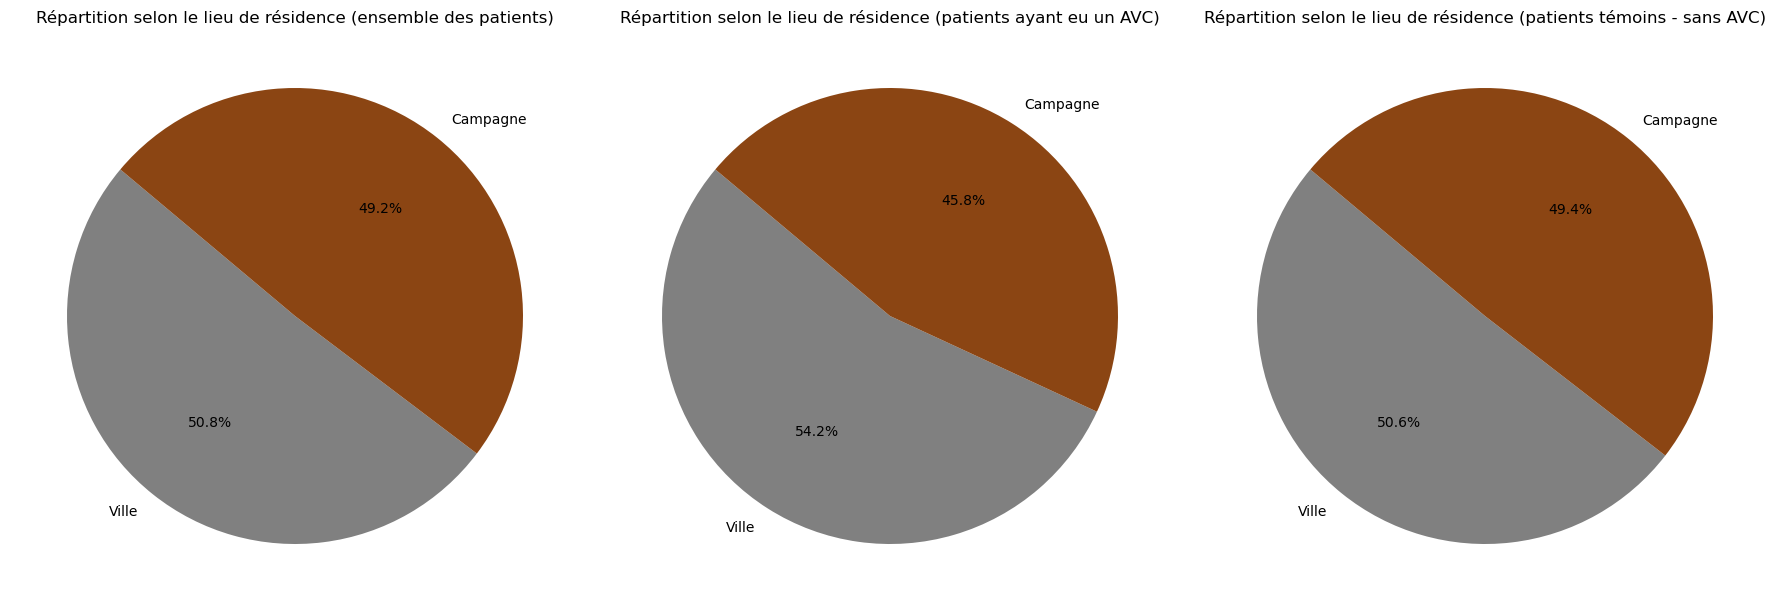

In [29]:
# Données pour le premier camembert (ensemble des patients)
urbains_all = (df['Residence_type'] == 'Urban').sum()
ruraux_all = (df['Residence_type'] == 'Rural').sum()
nombre_patients_all = [urbains_all, ruraux_all]
labels_all = ['Ville', 'Campagne']
colors_all = ['grey', '#8B4513']

# Données pour le deuxième camembert (patients ayant eu un AVC)
urbains_avc = (df_patient_avc['Residence_type'] == 'Urban').sum()
ruraux_avc = (df_patient_avc['Residence_type'] == 'Rural').sum()
nombre_patients_avc = [urbains_avc, ruraux_avc]
labels_avc = ['Ville', 'Campagne']
colors_avc = ['grey', '#8B4513']

# Données pour le troisième camembert (patients témoins - sans AVC)
urbains_no_avc = (df_patient_no_avc['Residence_type'] == 'Urban').sum()
ruraux_no_avc = (df_patient_no_avc['Residence_type'] == 'Rural').sum()
nombre_patients_no_avc = [urbains_no_avc, ruraux_no_avc]
labels_no_avc = ['Ville', 'Campagne']
colors_no_avc = ['grey', '#8B4513']

# Créer le subplot avec trois camemberts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Premier camembert : ensemble des patients
axs[0].pie(nombre_patients_all, labels=labels_all, colors=colors_all, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Répartition selon le lieu de résidence (ensemble des patients)')

# Deuxième camembert : patients ayant eu un AVC
axs[1].pie(nombre_patients_avc, labels=labels_avc, colors=colors_avc, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Répartition selon le lieu de résidence (patients ayant eu un AVC)')

# Troisième camembert : patients témoins - sans AVC
axs[2].pie(nombre_patients_no_avc, labels=labels_no_avc, colors=colors_no_avc, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Répartition selon le lieu de résidence (patients témoins - sans AVC)')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()

Peut-être qu'habiter en ville augmenterait légèrement les chances d'AVC.

### ► Âge

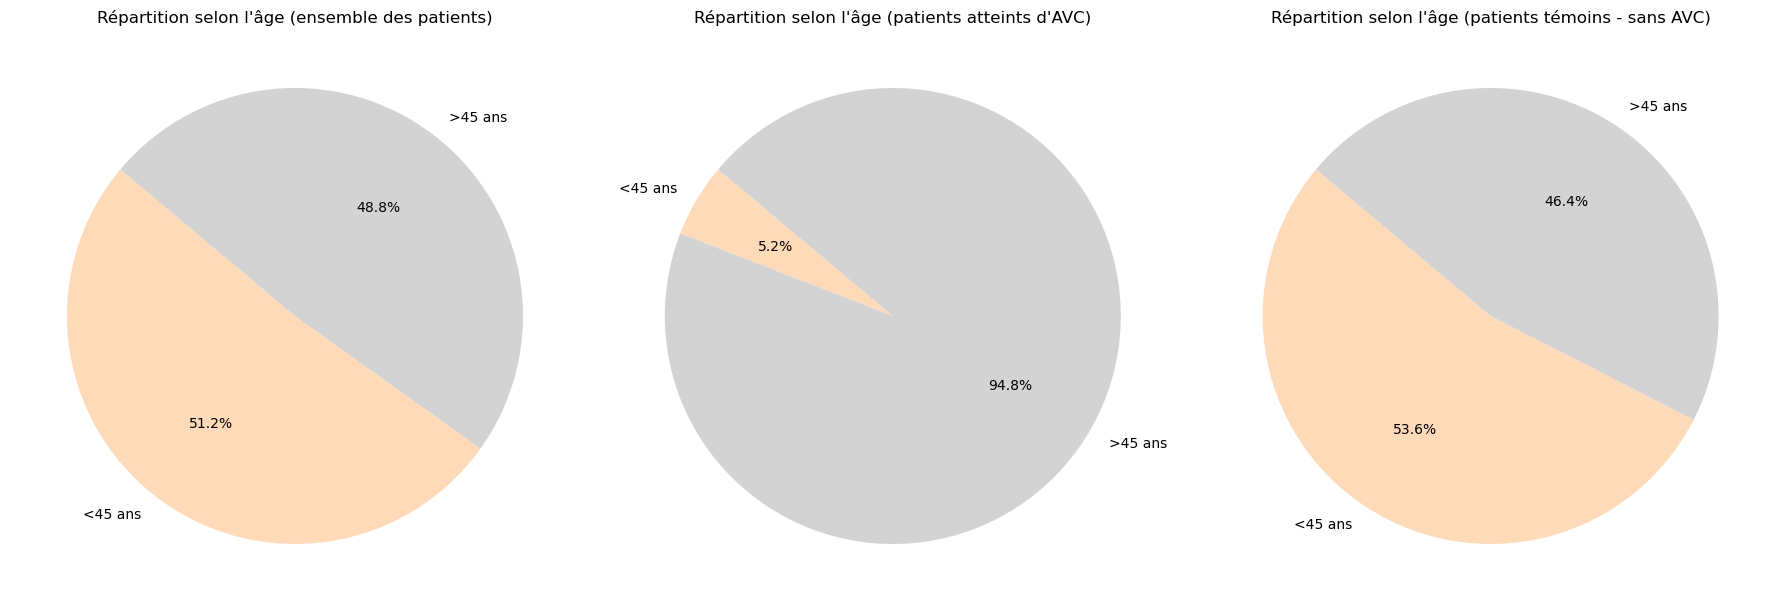

In [30]:
# Données pour le premier camembert (ensemble des patients)
jeunes_all = (df['age'] <= 45).sum()
vieux_all = (df['age'] > 45).sum()
nombre_patients_all = [jeunes_all, vieux_all]
labels_all = ['<45 ans', '>45 ans']
colors_all = ['#FFDAB9', 'lightgrey']

# Données pour le deuxième camembert (patients ayant eu un AVC)
jeunes_avc = (df_patient_avc['age'] <= 45).sum()
vieux_avc = (df_patient_avc['age'] > 45).sum()
nombre_patients_avc = [jeunes_avc, vieux_avc]
labels_avc = ['<45 ans', '>45 ans']
colors_avc = ['#FFDAB9', 'lightgrey']

# Données pour le troisième camembert (patients témoins - sans AVC)
jeunes_no_avc = (df_patient_no_avc['age'] <= 45).sum()
vieux_no_avc = (df_patient_no_avc['age'] > 45).sum()
nombre_patients_no_avc = [jeunes_no_avc, vieux_no_avc]
labels_no_avc = ['<45 ans', '>45 ans']
colors_no_avc = ['#FFDAB9', 'lightgrey']

# Créer le subplot avec trois camemberts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Premier camembert : ensemble des patients
axs[0].pie(nombre_patients_all, labels=labels_all, colors=colors_all, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Répartition selon l\'âge (ensemble des patients)')

# Deuxième camembert : patients ayant eu un AVC
axs[1].pie(nombre_patients_avc, labels=labels_avc, colors=colors_avc, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Répartition selon l\'âge (patients atteints d\'AVC)')

# Troisième camembert : patients témoins - sans AVC
axs[2].pie(nombre_patients_no_avc, labels=labels_no_avc, colors=colors_no_avc, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Répartition selon l\'âge (patients témoins - sans AVC)')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()

L'âge a une forte incidence sur les chances d'avoir un AVC.

### ► Hypertension

In [31]:
tension_no_avc = (df_patient_no_avc['hypertension'] == 1).sum()
tension_avc = (df_patient_avc['hypertension'] == 1).sum()
print(f"Les patients faisant de l'hypertension représentent {round(100*(tension_no_avc/df_patient_no_avc.shape[0]))}% chez les témoins et {round(100*(tension_avc/df_patient_no_avc.shape[0]))}% chez les atteints.")

Les patients faisant de l'hypertension représentent 9% chez les témoins et 1% chez les atteints.


À priori, l'hypertension est une variable à écarter.

### ► Maladie cardiaque

In [32]:
cardio_no_avc = (df_patient_no_avc['heart_disease'] == 1).sum()
cardio_avc = (df_patient_avc['heart_disease'] == 1).sum()
print(f"Les patients ayant des problèmes cardiaques représentent {round(100*(cardio_no_avc/df_patient_no_avc.shape[0]))}% chez les témoins et {round(100*(cardio_avc/df_patient_no_avc.shape[0]))}% chez les atteints.")

Les patients ayant des problèmes cardiaques représentent 5% chez les témoins et 1% chez les atteints.


Idem pour les maladies cardiaques.

### ► Incidence du mariage

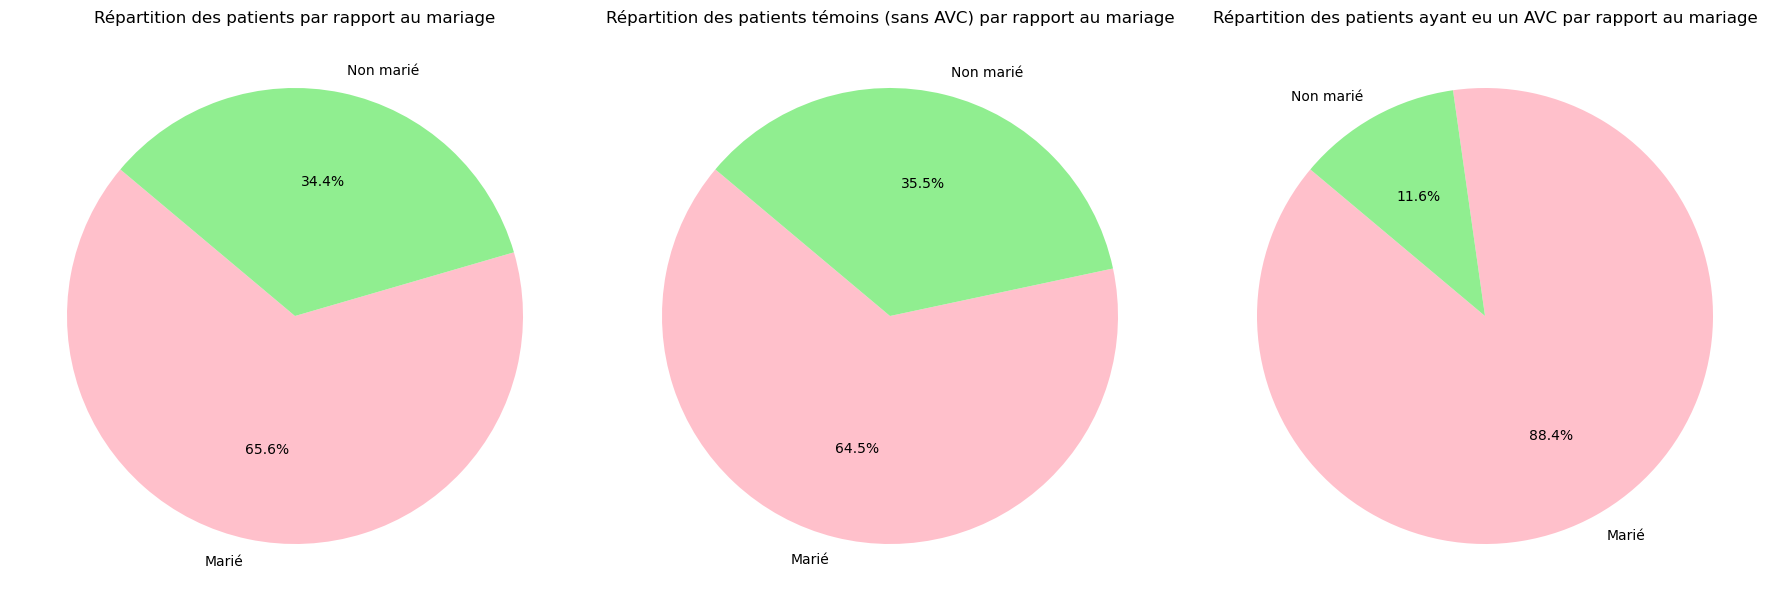

In [35]:
# Données pour le premier camembert (ensemble des patients)
wedding_all = (df['ever_married'] == 'Yes').sum()
no_wedding_all = (df['ever_married'] == 'No').sum()
nombre_patients_all = [wedding_all, no_wedding_all]
labels_all = ['Marié', 'Non marié']
colors_all = ['#FFC0CB', 'lightgreen']

# Données pour le deuxième camembert (patients témoins - sans AVC)
wedding_no_avc = (df_patient_no_avc['ever_married'] == 'Yes').sum()
no_wedding_no_avc = (df_patient_no_avc['ever_married'] == 'No').sum()
nombre_patients_no_avc = [wedding_no_avc, no_wedding_no_avc]
labels_no_avc = ['Marié', 'Non marié']
colors_no_avc = ['#FFC0CB', 'lightgreen']

# Données pour le troisième camembert (patients ayant eu un AVC)
wedding_avc = (df_patient_avc['ever_married'] == 'Yes').sum()
no_wedding_avc = (df_patient_avc['ever_married'] == 'No').sum()
nombre_patients_avc = [wedding_avc, no_wedding_avc]
labels_avc = ['Marié', 'Non marié']
colors_avc = ['#FFC0CB', 'lightgreen']

# Créer le subplot avec trois camemberts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Premier camembert : ensemble des patients
axs[0].pie(nombre_patients_all, labels=labels_all, colors=colors_all, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Répartition des patients par rapport au mariage')

# Deuxième camembert : patients témoins - sans AVC
axs[1].pie(nombre_patients_no_avc, labels=labels_no_avc, colors=colors_no_avc, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Répartition des patients témoins (sans AVC) par rapport au mariage')

# Troisième camembert : patients ayant eu un AVC
axs[2].pie(nombre_patients_avc, labels=labels_avc, colors=colors_avc, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Répartition des patients ayant eu un AVC par rapport au mariage')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()

Peut-être le mariage augmenterait les risques d'avoir un AVC.

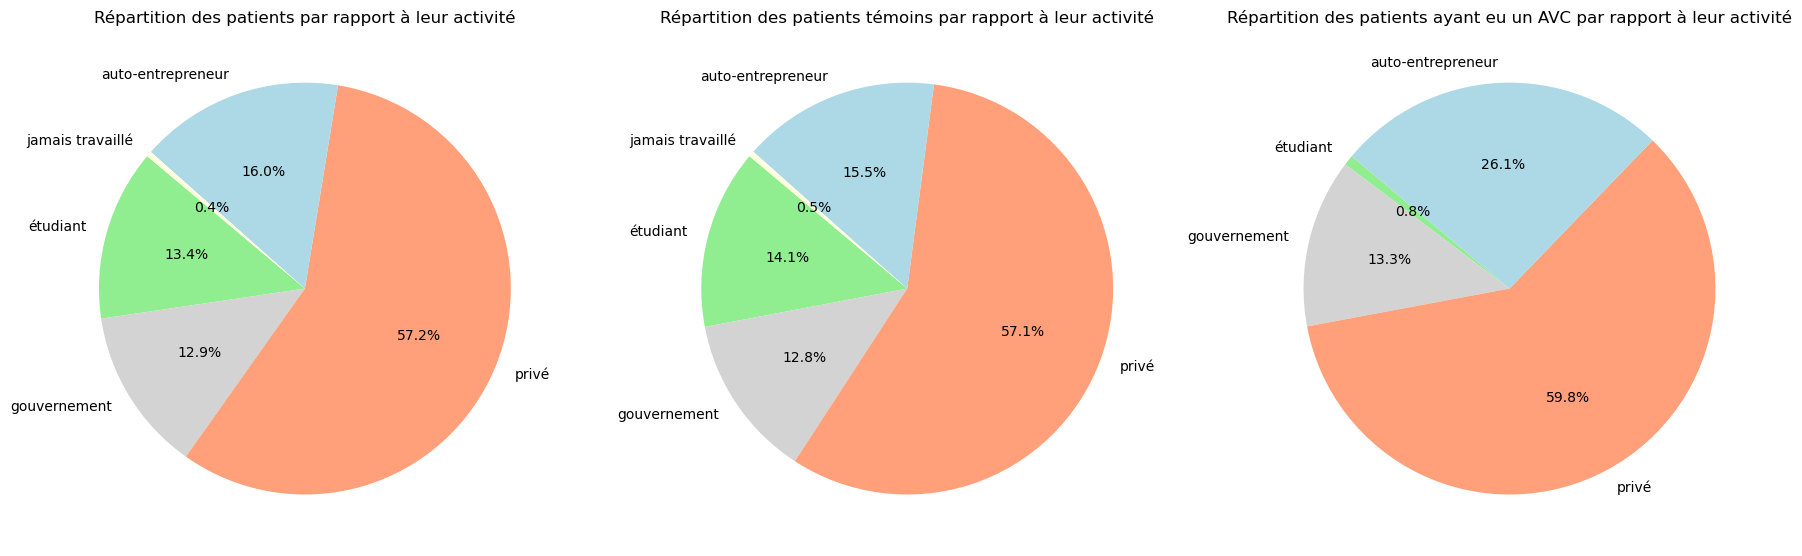

In [99]:
# Données pour le premier camembert (ensemble des patients)
work1_all = (df['work_type'] == 'children').sum()
work2_all = (df['work_type'] == 'Govt_job').sum()
work3_all = (df['work_type'] == 'Private').sum()
work4_all = (df['work_type'] == 'Self-employed').sum()
work5_all = (df['work_type'] == 'Never_worked').sum()
nombre_patients_all = [work1_all, work2_all, work3_all, work4_all, work5_all]
labels_all = ['étudiant', 'gouvernement','privé','auto-entrepreneur','jamais travaillé']
colors_all = ['lightgreen', 'lightgrey','#FFA07A','lightblue','lightyellow']

# Données pour le deuxième camembert (patients témoins - sans AVC)
work1_no_avc = (df_patient_no_avc['work_type'] == 'children').sum()
work2_no_avc = (df_patient_no_avc['work_type'] == 'Govt_job').sum()
work3_no_avc = (df_patient_no_avc['work_type'] == 'Private').sum()
work4_no_avc = (df_patient_no_avc['work_type'] == 'Self-employed').sum()
work5_no_avc = (df_patient_no_avc['work_type'] == 'Never_worked').sum()
nombre_patients_no_avc = [work1_no_avc, work2_no_avc, work3_no_avc, work4_no_avc, work5_no_avc]
labels_no_avc = ['étudiant', 'gouvernement','privé','auto-entrepreneur','jamais travaillé']
colors_no_avc = ['lightgreen', 'lightgrey','#FFA07A','lightblue','lightyellow']

# Données pour le troisième camembert (patients ayant eu un AVC)
work1_avc = (df_patient_avc['work_type'] == 'children').sum()
work2_avc = (df_patient_avc['work_type'] == 'Govt_job').sum()
work3_avc = (df_patient_avc['work_type'] == 'Private').sum()
work4_avc = (df_patient_avc['work_type'] == 'Self-employed').sum()
nombre_patients_avc = [work1_avc, work2_avc, work3_avc, work4_avc]
labels_avc = ['étudiant', 'gouvernement','privé','auto-entrepreneur']
colors_avc = ['lightgreen', 'lightgrey','#FFA07A','lightblue']

# Créer le subplot avec trois camemberts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Premier camembert : ensemble des patients
axs[0].pie(nombre_patients_all, labels=labels_all, colors=colors_all, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Répartition des patients par rapport à leur activité')

# Deuxième camembert : patients témoins - sans AVC
axs[1].pie(nombre_patients_no_avc, labels=labels_no_avc, colors=colors_no_avc, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Répartition des patients témoins par rapport à leur activité')

# Troisième camembert : patients ayant eu un AVC
axs[2].pie(nombre_patients_avc, labels=labels_avc, colors=colors_avc, autopct='%1.1f%%', startangle=140)
axs[2].set_title('Répartition des patients ayant eu un AVC par rapport à leur activité')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher le subplot
plt.show()